##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rock, Paper & Scissors with TensorFlow Hub - TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%202/Exercise/TFLite_Week2_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%202/Exercise/TFLite_Week2_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.0.0
• Using TensorFlow Hub Version:  0.7.0
• GPU Device Not Found. Running on CPU


## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [2]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [ ]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

splits, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [ ]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

Now shuffle and batch the data


In [3]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [ ]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = # YOUR CODE HERE

validation_batches = # YOUR CODE HERE

test_batches = # YOUR CODE HERE

Inspect a batch

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

## Solution data preprocessing without tfds

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

In [11]:
import os
import zipfile

local_zip = './tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp/')
zip_ref.close()

local_zip = './tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp/')
zip_ref.close()


rock_dir = os.path.join('./tmp/rps/rock')
paper_dir = os.path.join('./tmp/rps/paper')
scissors_dir = os.path.join('./tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png', 'rock01-005.png', 'rock01-006.png', 'rock01-007.png', 'rock01-008.png', 'rock01-009.png']
['paper01-000.png', 'paper01-001.png', 'paper01-002.png', 'paper01-003.png', 'paper01-004.png', 'paper01-005.png', 'paper01-006.png', 'paper01-007.png', 'paper01-008.png', 'paper01-009.png']
['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png', 'scissors01-005.png', 'scissors01-006.png', 'scissors01-007.png', 'scissors01-008.png', 'scissors01-009.png']


In [3]:
TRAINING_DIR = "./tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "./tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='sparse'
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.



## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [4]:
do_fine_tuning = False #@param {type:"boolean"}

In [5]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [6]:
print("Building model with", MODULE_HANDLE)
num_classes = 3

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## Training the Model

In [8]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [9]:
EPOCHS = 5

hist = model.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator)

Train for 79 steps, validate for 12 steps
Epoch 1/5
79/79 [==============================] - 62s 790ms/step - loss: 0.3857 - accuracy: 0.8710 - val_loss: 0.3499 - val_accuracy: 0.8898
Epoch 2/5
79/79 [==============================] - 59s 741ms/step - loss: 0.1252 - accuracy: 0.9746 - val_loss: 0.3835 - val_accuracy: 0.8226
Epoch 3/5
79/79 [==============================] - 57s 725ms/step - loss: 0.0779 - accuracy: 0.9857 - val_loss: 0.2944 - val_accuracy: 0.8656
Epoch 4/5
79/79 [==============================] - 56s 712ms/step - loss: 0.0593 - accuracy: 0.9901 - val_loss: 0.3335 - val_accuracy: 0.8548
Epoch 5/5
79/79 [==============================] - 56s 711ms/step - loss: 0.0477 - accuracy: 0.9913 - val_loss: 0.3516 - val_accuracy: 0.8468


## Export the Model

In [10]:
RPS_SAVED_MODEL = "rps_saved_model"

Export the SavedModel

In [11]:
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model
tf.saved_model.save(model, RPS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: rps_saved_model\assets


INFO:tensorflow:Assets written to: rps_saved_model\assets


In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

In [14]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [18]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert Using TFLite's Converter

In [12]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

In [13]:
tflite_model_file = 'mobilenet_v1_1.0_224_quant.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

### File converted by teacher:
it has quantization!!

In [2]:
tflite_model_file = 'mobilenet_v1_1.0_224_quant.tflite'
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [3]:
 interpreter.get_input_details()

[{'name': 'input',
  'index': 88,
  'shape': array([  1, 224, 224,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128)}]

### File converted by me:
it has NOOOOOO quantization!!

In [14]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [15]:
 interpreter.get_input_details()

[{'name': 'keras_layer_input',
  'index': 175,
  'shape': array([  1, 224, 224,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [16]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
# for img, label in tqdm(test_batches.take(10)):
img, label = validation_generator.next()
interpreter.set_tensor(input_index, tf.convert_to_tensor(img[0:1]))
interpreter.invoke()

predictions.append(interpreter.get_tensor(output_index))

test_labels.append(label[0])
test_imgs.append(img[0:1])

In [18]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['paper', 'rock' , 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[int(true_label)]), color=color)

<class 'numpy.int64'> <class 'numpy.float32'>


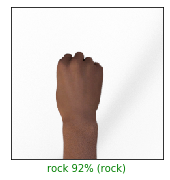

In [19]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Create a file to save the labels.

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

If you are running this notebook in a Colab, you can run the cell below to download the model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [ ]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

# Prepare the Test Images for Download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq rps_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [ ]:
try:
    files.download('rps_test_images.zip')
except:
    pass